In [ ]:
library(Seurat)
library(dplyr)
library(ggplot2)
library(tidyverse)
library(patchwork)
library(harmony)
library(readxl)
library(viridis)

options(warn = -1)
library(future)
availableCores()
options(future.globals.maxSize = 50 * 1024^4)
plan("multicore", workers = 30)

source('/data/work/01.script/HELP/seurat_help.r/cluster_proportion_trend.R')
source('/data/work/01.script/HELP/seurat_help.r/multi_cluster_volcano.R')
source('/data/work/01.script/HELP/seurat_help.r/plot_volcano.R')
source('/data/work/01.script/HELP/seurat_help.r/Sankey_bar.R')

## function & color

In [2]:
colorlist = c("#FFFF00", "#1CE6FF", "#FF34FF", "#FF4A46", "#008941","#006FA6", "#A30059", "#FFE4E1", "#0000A6", "#63FFAC","#B79762", "#004D43", "#8FB0FF", 
              "#997D87", "#5A0007","#809693", "#1B4400", "#4FC601", "#3B5DFF", "#FF2F80","#BA0900", "#6B7900", "#00C2A0", "#FFAA92", "#FF90C9","#B903AA", 
              "#DDEFFF", "#7B4F4B", "#A1C299", "#0AA6D8","#00A087FF", "#4DBBD5FF", "#E64B35FF", "#3C5488FF", "#F38400","#A1CAF1", "#C2B280", "#848482", 
              "#E68FAC", "#0067A5","#F99379", "#604E97", "#F6A600", "#B3446C", "#DCD300","#882D17", "#8DB600", "#654522", "#E25822", "#2B3D26","#191970", 
              "#000080","#6495ED", "#1E90FF", "#00BFFF", "#00FFFF", "#FF1493","#FF00FF", "#A020F0", "#63B8FF", "#008B8B", "#54FF9F","#00FF00", "#76EE00", "#FFF68F")

# if (length(Cells(combined))>60000) {
#     draw_obj = subset(combined, cells=sample(Cells(combined), 50000))
# } else {
#     draw_obj = combined
# }

plots <- function(obj, group_name, prefix, ...){
    
    colors = colorlist[1:length(unique(obj@meta.data[[group_name]]))]
    names(colors) = unique(obj@meta.data[[group_name]])
    
    p <- DimPlot(obj, group.by=group_name, pt.size=0.1, label.size = 8, cols=colors, raster=F, ...)
    print(p)
    ggsave(paste0(prefix, "_", group_name, ".png"),width=15,height=14, dpi = 300)
    
}

plots_split <- function(obj, draw_obj, group_name, prefix, ...){
    
    if (length(Cells(obj))>60000) {
    draw_obj = subset(obj, cells=sample(Cells(obj), 50000))
    } else {
        draw_obj = obj
    }
    
    colors = colorlist[1:length(unique(obj@meta.data[[group_name]]))]
    names(colors) = unique(obj@meta.data[[group_name]])
    
    pdf(paste0(prefix, "_", group_name, "_split.pdf"))
    for (i in sort(unique(draw_obj@meta.data[[group_name]]))){
        cells = Cells(draw_obj)[draw_obj@meta.data[[group_name]]==i]
        p <- DimPlot(draw_obj, group.by=group_name, cells.highlight=cells)
        print(p+ggtitle(i))
    }
    dev.off()
}

In [73]:
cor_epi = c( "Normal Squamous Cell" = "#BC3C29FF" ,"LUSC Tumor Cell" = "#DC050C",
              "LUSC Secretory Cell"="#FF7F00", 
              "LUSC Proliferative Cell" = "#F4C40F", 
              "LUSC Basal Cell" = "#FDAF91FF",
              "Ciliated Cell" = "#00A3D0", 
              "Cancer Stem Cell" = "#b01d23", "AT1" = "#5CBD92","AT2" = '#98DF8A')

cor_main = c("Epithelial Cell" = "#DC050C","Immune Cell" = "#8126C0", "Stromal Cell" = "#00A84E")
            
cor_sample <- c(
  # N系列 - 绿色系
  "N1" = "#33A02C", "N2" = "#98DF8A", "N3" = "#00A84E", "N4" = "#2BCE48",
  # E系列 - 黄色系
  "E1" = "#F6F926", "E2" = "#e7c158", "E3" = "#F4C40F", "E4" = "#FF7F00",
  # M系列 - 红色系
  "M1" = "#b02a2b", "M2" = "#DC050C", "M3" = "#BE0032", "M4" = "#FC0080")

cor_stage <- c(
  "normal" = "#33A02C", # N系列 - 绿色系
  "early" = "#FF7F00", # E系列 - 黄色系
  "middle" = "#BE0032" # M系列 - 红色系
)

cor_type = c( "Tumor" = "#aa2a29", "Normal" = "#00A84E")



## 00.input

In [67]:
obj <- readRDS('/data/work/02.result/others/Chen/proj_lusc/zbl/02.result/end_plot/epi_del/epi_del_20605.rds')
obj

An object of class Seurat 
39434 features across 20605 samples within 1 assay 
Active assay: RNA (39434 features, 3000 variable features)
 3 dimensional reductions calculated: pca, harmony, umap

In [68]:
table(obj$sample)
table(obj$stage)
table(obj$type)
table(obj$Epi_celltype)


  E1   E2   E3   E4   M1   M2   M3   M4   N1   N2   N3   N4 
3344 2550 4098 4816   54  144 1432 2350  161  685  278  693 


normal  early middle 
  1817  14808   3980 


Normal  Tumor 
  1817  18788 


               AT1                AT2 Bronchial_Ciliated        Cancer_Stem 
               357               1660                329                287 
        LUSC_basal         LUSC_tumor    Normal_Squamous  SCC_Proliferative 
              2363               3559               6689               2866 
     SCC_Secretory 
              2495 

In [69]:
table(obj$Epi_celltype,obj$type)

                    
                     Normal Tumor
  AT1                   327    30
  AT2                  1213   447
  Bronchial_Ciliated    276    53
  Cancer_Stem             1   286
  LUSC_basal              0  2363
  LUSC_tumor              0  3559
  Normal_Squamous         0  6689
  SCC_Proliferative       0  2866
  SCC_Secretory           0  2495

## (1) anno edit

In [70]:
# obj$Epi_celltype[obj$Epi_celltype == 'Bronchial_Ciliated'] <- 'Ciliated Cell'
# obj$Epi_celltype[obj$Epi_celltype == 'Cancer_Stem'] <- 'Cancer Stem Cell'
# obj$Epi_celltype[obj$Epi_celltype == 'SCC_Proliferative'] <- 'LUSC Proliferative Cell'
# obj$Epi_celltype[obj$Epi_celltype == 'SCC_Secretory'] <- 'LUSC Secretory Cell'
# obj$Epi_celltype[obj$Epi_celltype == 'LUSC_basal'] <- 'LUSC Basal Cell'
# obj$Epi_celltype[obj$Epi_celltype == 'Normal_Squamous'] <- 'Normal Squamous Cell'
# obj$Epi_celltype[obj$Epi_celltype == 'LUSC_tumor'] <- 'LUSC Tumor Cell'

table(obj$Epi_celltype,obj$type)



                         
                          Normal Tumor
  AT1                        327    30
  AT2                       1213   447
  Cancer Stem Cell             1   286
  Ciliated Cell              276    53
  LUSC Basal Cell              0  2363
  LUSC Proliferative Cell      0  2866
  LUSC Secretory Cell          0  2495
  LUSC Tumor Cell              0  3559
  Normal Squamous Cell         0  6689

In [71]:
obj$Epi_celltype <- factor(obj$Epi_celltype, levels = c('Normal Squamous Cell','LUSC Proliferative Cell','LUSC Secretory Cell','LUSC Basal Cell','LUSC Tumor Cell',
                                                        'Ciliated Cell','Cancer Stem Cell','AT1','AT2'))
table(obj$Epi_celltype,obj$type)

                         
                          Normal Tumor
  Normal Squamous Cell         0  6689
  LUSC Proliferative Cell      0  2866
  LUSC Secretory Cell          0  2495
  LUSC Basal Cell              0  2363
  LUSC Tumor Cell              0  3559
  Ciliated Cell              276    53
  Cancer Stem Cell             1   286
  AT1                        327    30
  AT2                       1213   447

In [90]:
saveRDS(obj,'../epi_end_0411.rds')

## (2) plot

In [51]:
setwd('/data/work/02.result/others/Chen/proj_lusc/zbl/02.result/end_plot/epi_del/fig')

### 2.1 umap

In [53]:
setwd('/data/work/02.result/others/Chen/proj_lusc/zbl/02.result/end_plot/epi_del/fig/umap/')

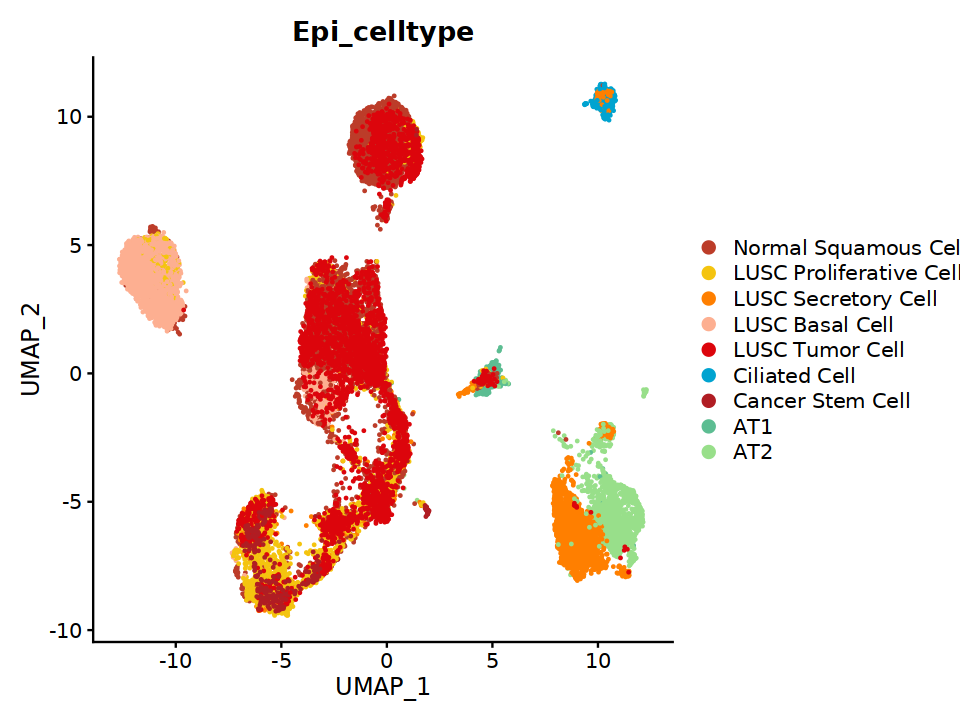

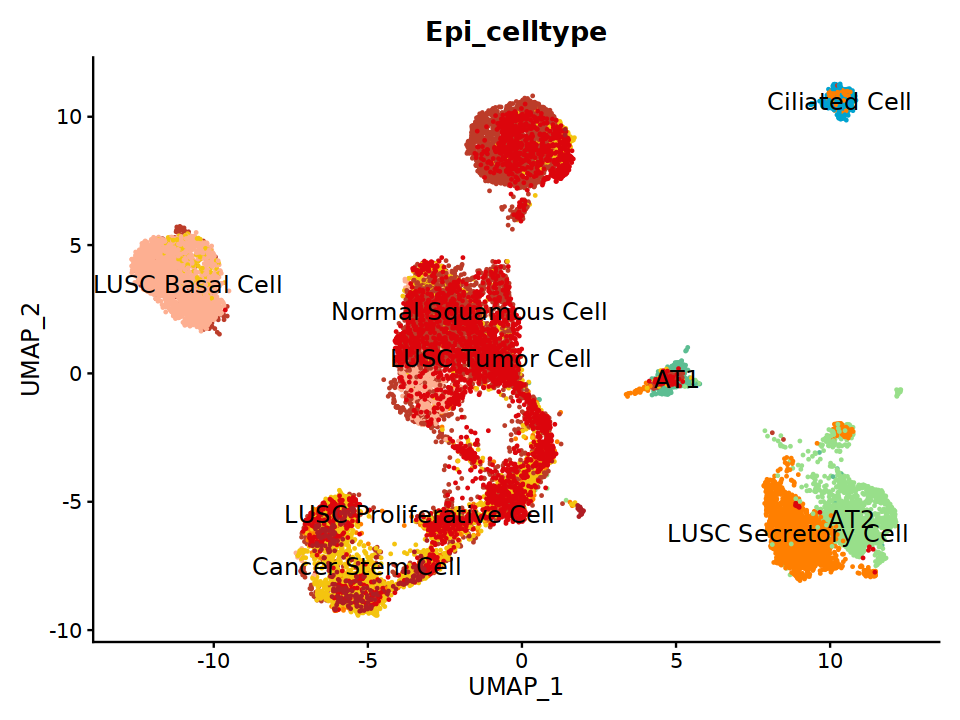

In [74]:
# sub
options(repr.plot.width=8,repr.plot.height=6)

group = 'Epi_celltype'

p <- DimPlot(obj, group.by = group, pt.size=0.3, label.size = 8, cols = cor_epi, raster=F) 
p
ggsave(paste0(group,"_umap.png"), bg='white',width=11, height=9, dpi = 300)
ggsave(paste0(group,"_umap.pdf"), bg='white',width=11, height=9, dpi = 300)

p <- DimPlot(obj, group.by = group, pt.size=0.3, label.size = 5, label = T, cols = cor_epi, raster=F) + NoLegend()
p
ggsave(paste0(group,"_label_umap.png"), bg='white',width=9, height=9, dpi = 300)
ggsave(paste0(group,"_label_umap.pdf"), bg='white',width=9, height=9, dpi = 300)

In [110]:
plots_split(obj, draw_obj, 'Epi_celltype', 'split')

pdf 
  2

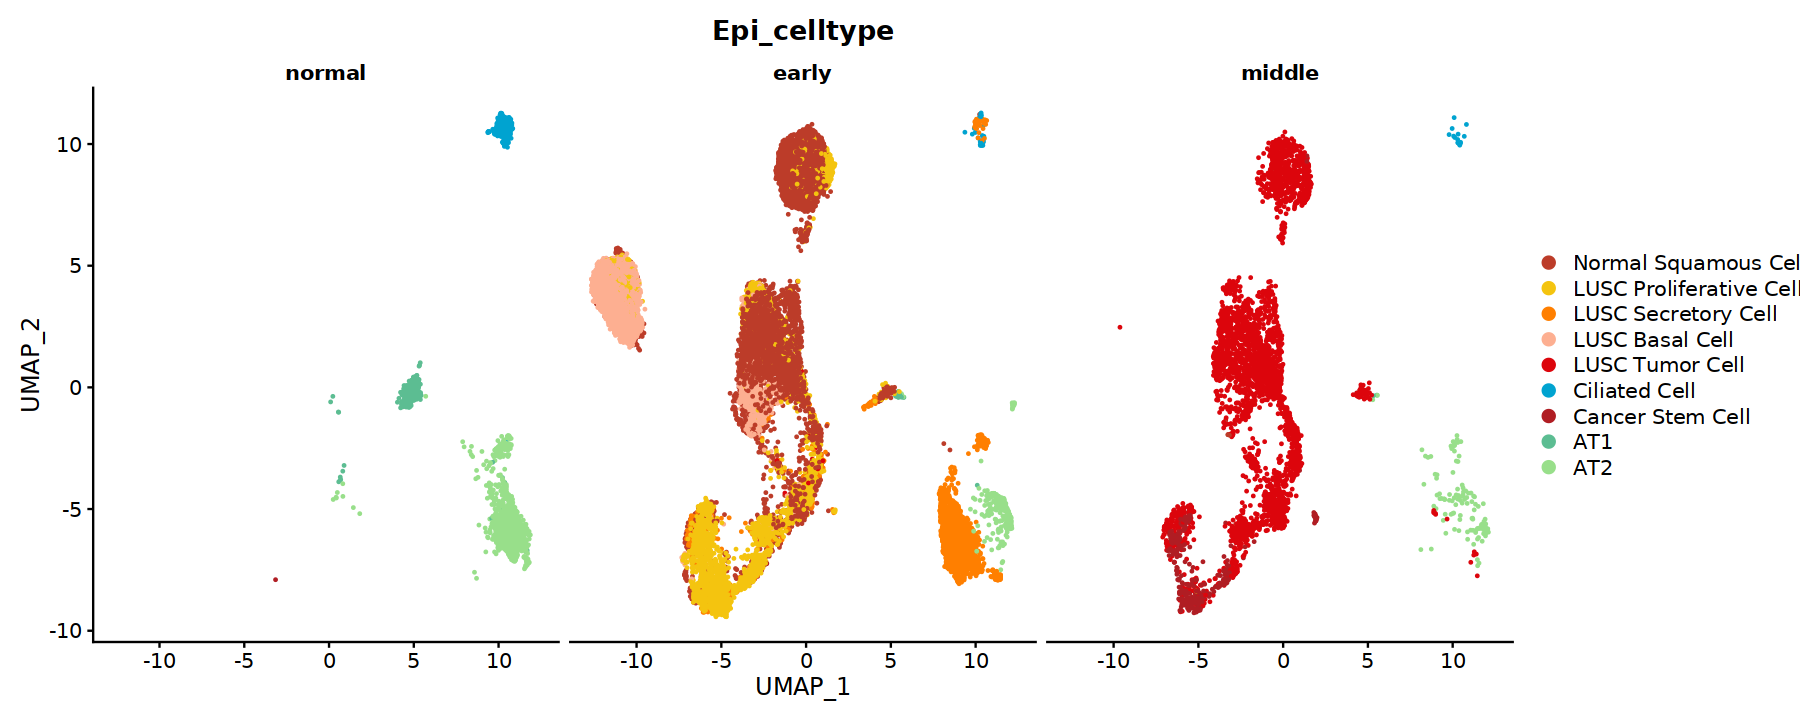

In [84]:
# sub split
options(repr.plot.width=15,repr.plot.height=6)

group = 'Epi_celltype'


p <- DimPlot(obj, group.by = group, split.by = 'stage',pt.size=0.3, label.size = 8, cols = cor_epi, raster=F) # label = T,
p
ggsave(paste0(group,"_split_stage_umap.png"), bg='white',width=16, height=6, dpi = 300)
ggsave(paste0(group,"_split_stage_umap.pdf"), bg='white',width=16, height=6, dpi = 300)

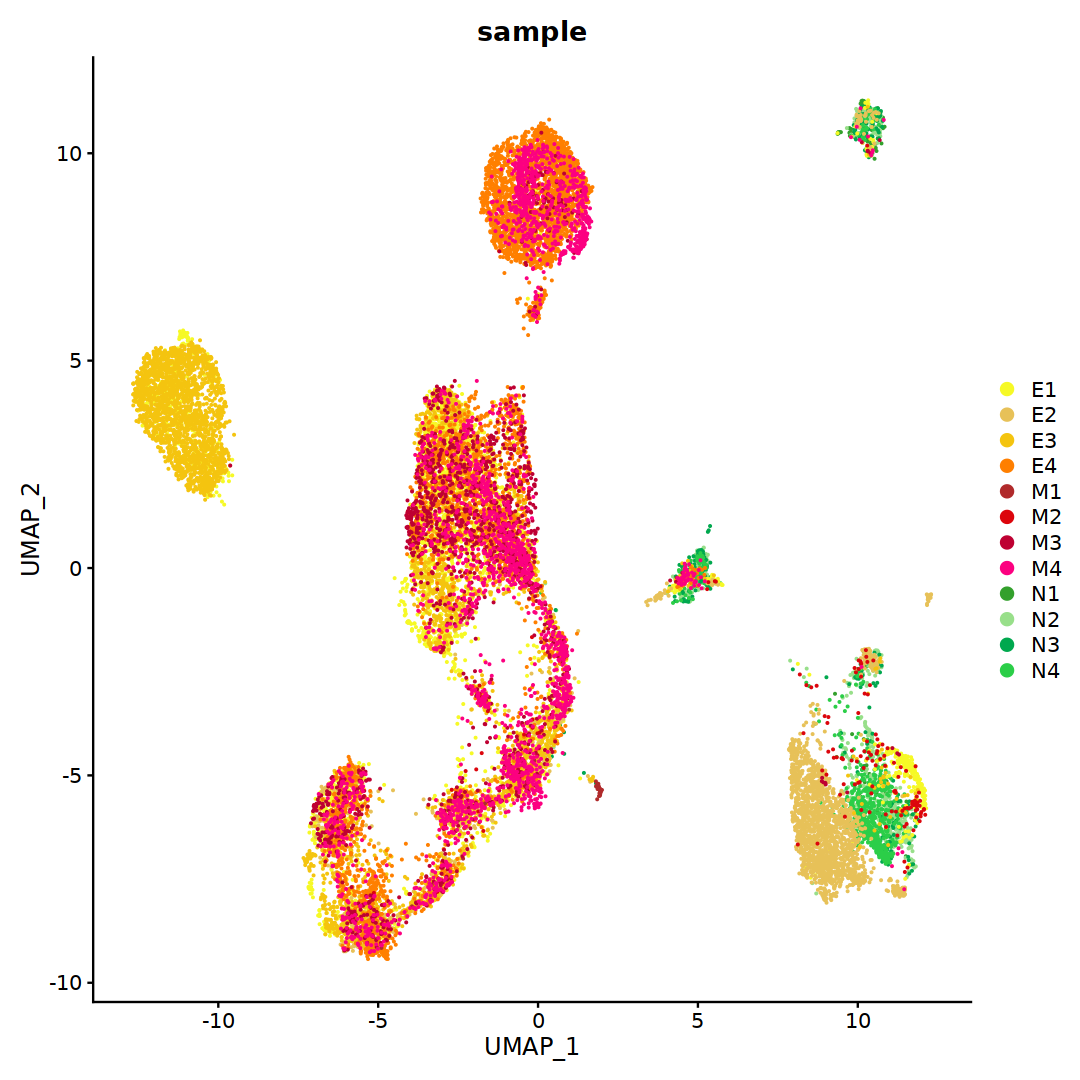

In [82]:
# sample
group = 'sample'

options(repr.plot.width=8,repr.plot.height=8)

p <- DimPlot(obj, group.by='sample', label.size = 8, cols = cor_sample, raster=F) #  pt.size=0.1,
p
ggsave(paste0(group,"_umap.png"), bg='white',width=10, height=9, dpi = 300)
ggsave(paste0(group,"_umap.pdf"), bg='white',width=10, height=9, dpi = 300)

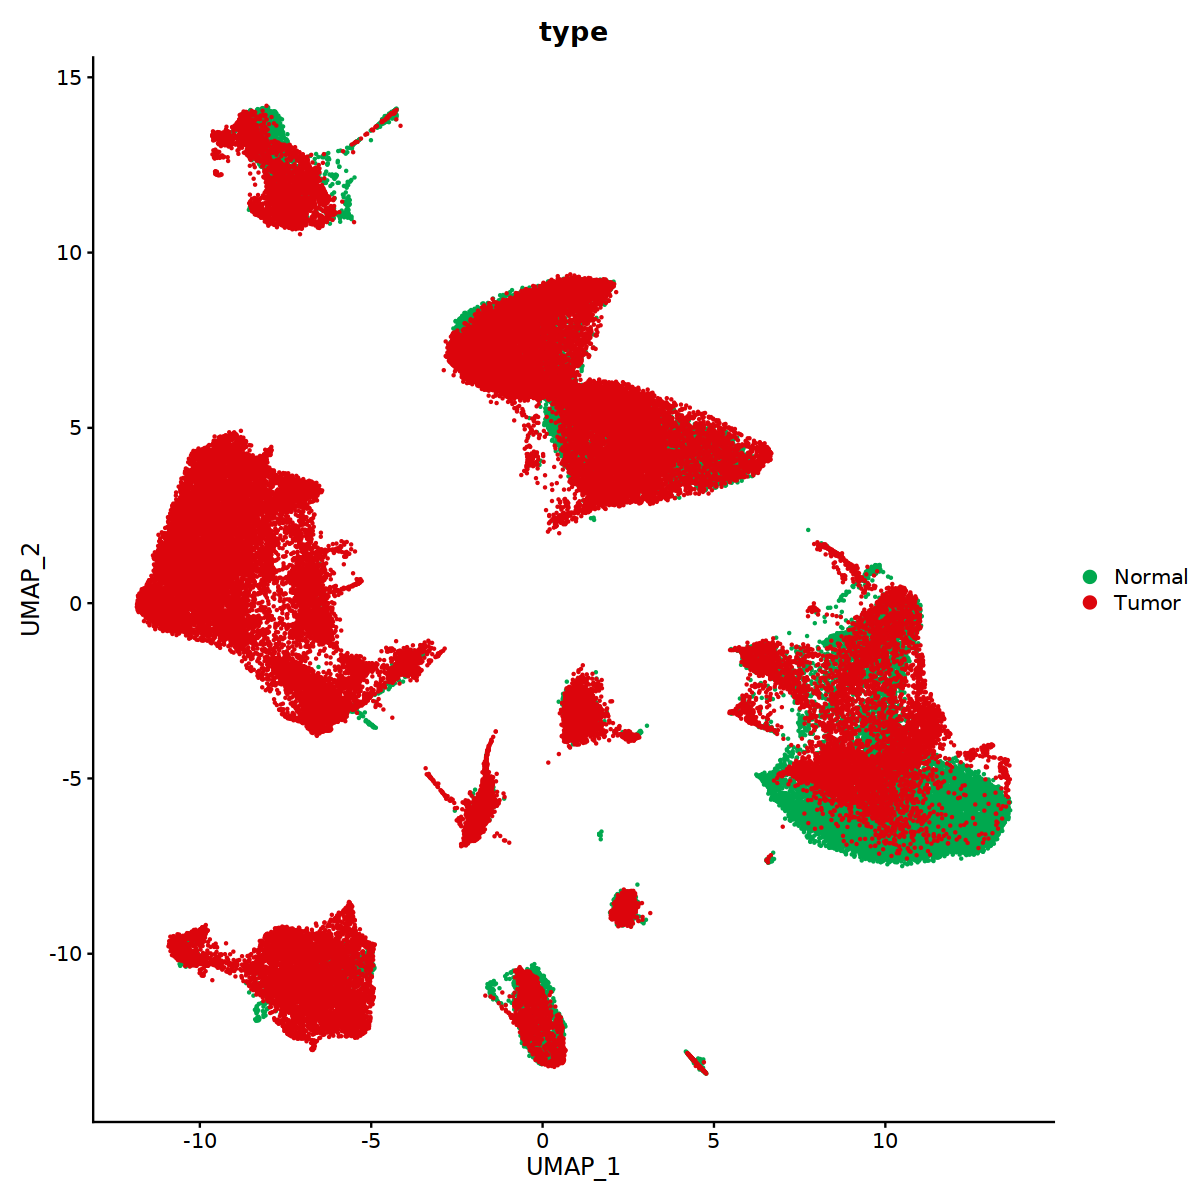

In [32]:
# type
options(repr.plot.width=12,repr.plot.height=10)

group = 'type'

p <- DimPlot(obj, group.by = group, pt.size=0.2, label.size = 8, cols = cor_sub, raster=F) # label = T,
p
ggsave(paste0(group,"_umap.png"), bg='white',width=10, height=9, dpi = 300)

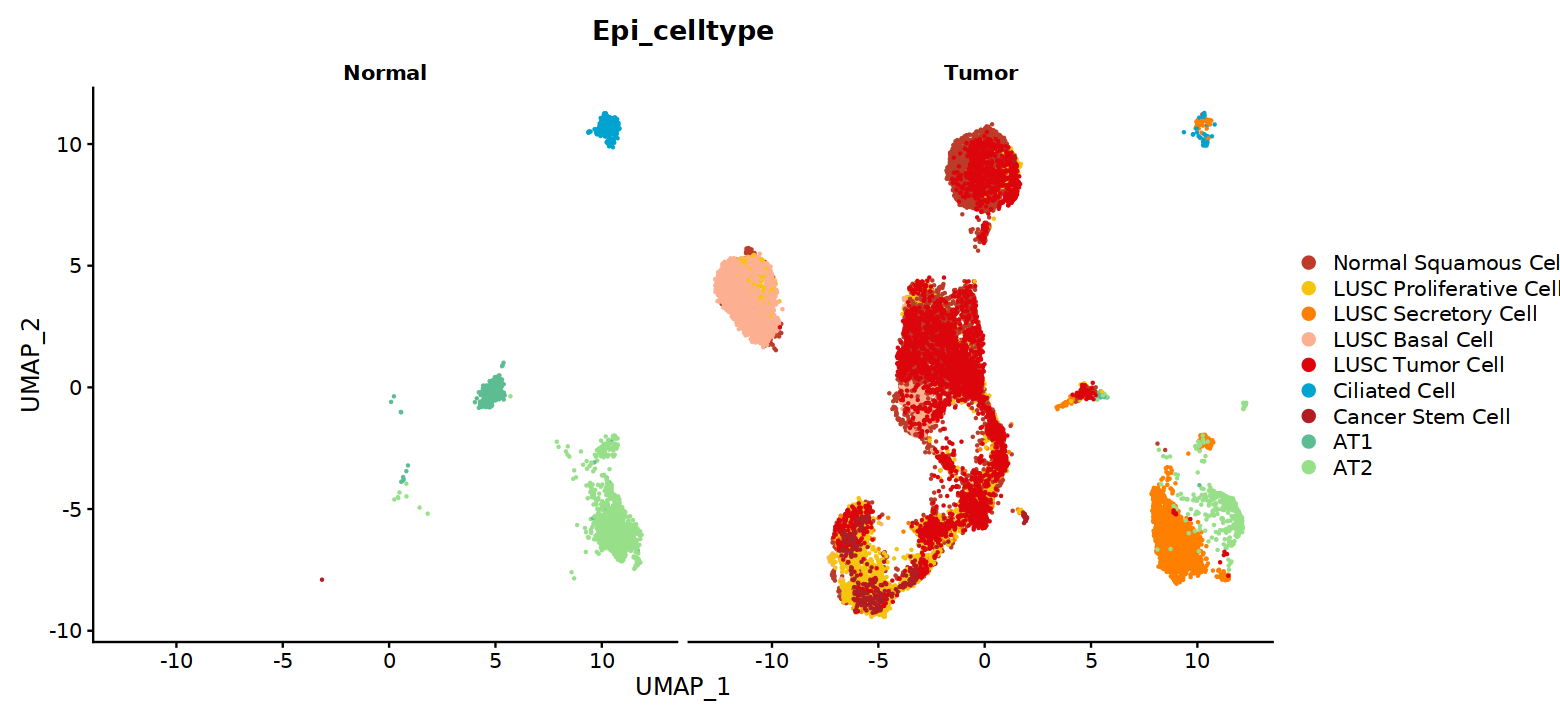

In [89]:
# Epi_celltype split by type
options(repr.plot.width=13,repr.plot.height=6)

group = 'Epi_celltype'

p <- DimPlot(obj, group.by = group, split.by = 'type',pt.size=0.2, label.size = 8, cols = cor_epi, raster=F) # label = T,
p
ggsave(paste0(group,"_split_type_umap.png"), bg='white',width=13, height=6, dpi = 300)
ggsave(paste0(group,"_split_type_umap.pdf"), bg='white',width=13, height=6, dpi = 300)

In [ ]:
# stage
options(repr.plot.width=8,repr.plot.height=6)

group = 'stage'

p <- DimPlot(obj, group.by = group, pt.size=0.3, label.size = 8, cols = cor_stage, raster=F) # label = T,
p
ggsave(paste0(group,"_umap.png"), bg='white',width=10, height=9, dpi = 300)
ggsave(paste0(group,"_umap.pdf"), bg='white',width=10, height=9, dpi = 300)

### 2.2 dotplot

In [91]:
unique(obj$Epi_celltype)

[1] Ciliated Cell           AT2                     AT1                    
[4] Cancer Stem Cell        Normal Squamous Cell    LUSC Tumor Cell        
[7] LUSC Proliferative Cell LUSC Secretory Cell     LUSC Basal Cell        
9 Levels: Normal Squamous Cell LUSC Proliferative Cell ... AT2

In [100]:
obj$Epi_celltype_plot <- obj$Epi_celltype
obj$Epi_celltype_plot <- factor(obj$Epi_celltype_plot, levels = c('AT1','AT2','Ciliated Cell','Cancer Stem Cell','LUSC Proliferative Cell',
                                                                  'LUSC Basal Cell','LUSC Tumor Cell','LUSC Secretory Cell',
                                                                  'Normal Squamous Cell'))

In [109]:
# FindAllMarkers
DefaultAssay(obj) = 'RNA'
Idents(obj) <- 'Epi_celltype'
marker <- FindAllMarkers(obj, logfc.threshold = 0.3)
write.csv(marker,paste0("Epi_celltype_markers_new.csv"))

Calculating cluster Normal Squamous Cell

Calculating cluster LUSC Proliferative Cell

Calculating cluster LUSC Secretory Cell

Calculating cluster LUSC Basal Cell

Calculating cluster LUSC Tumor Cell

Calculating cluster Ciliated Cell

Calculating cluster Cancer Stem Cell

Calculating cluster AT1

Calculating cluster AT2



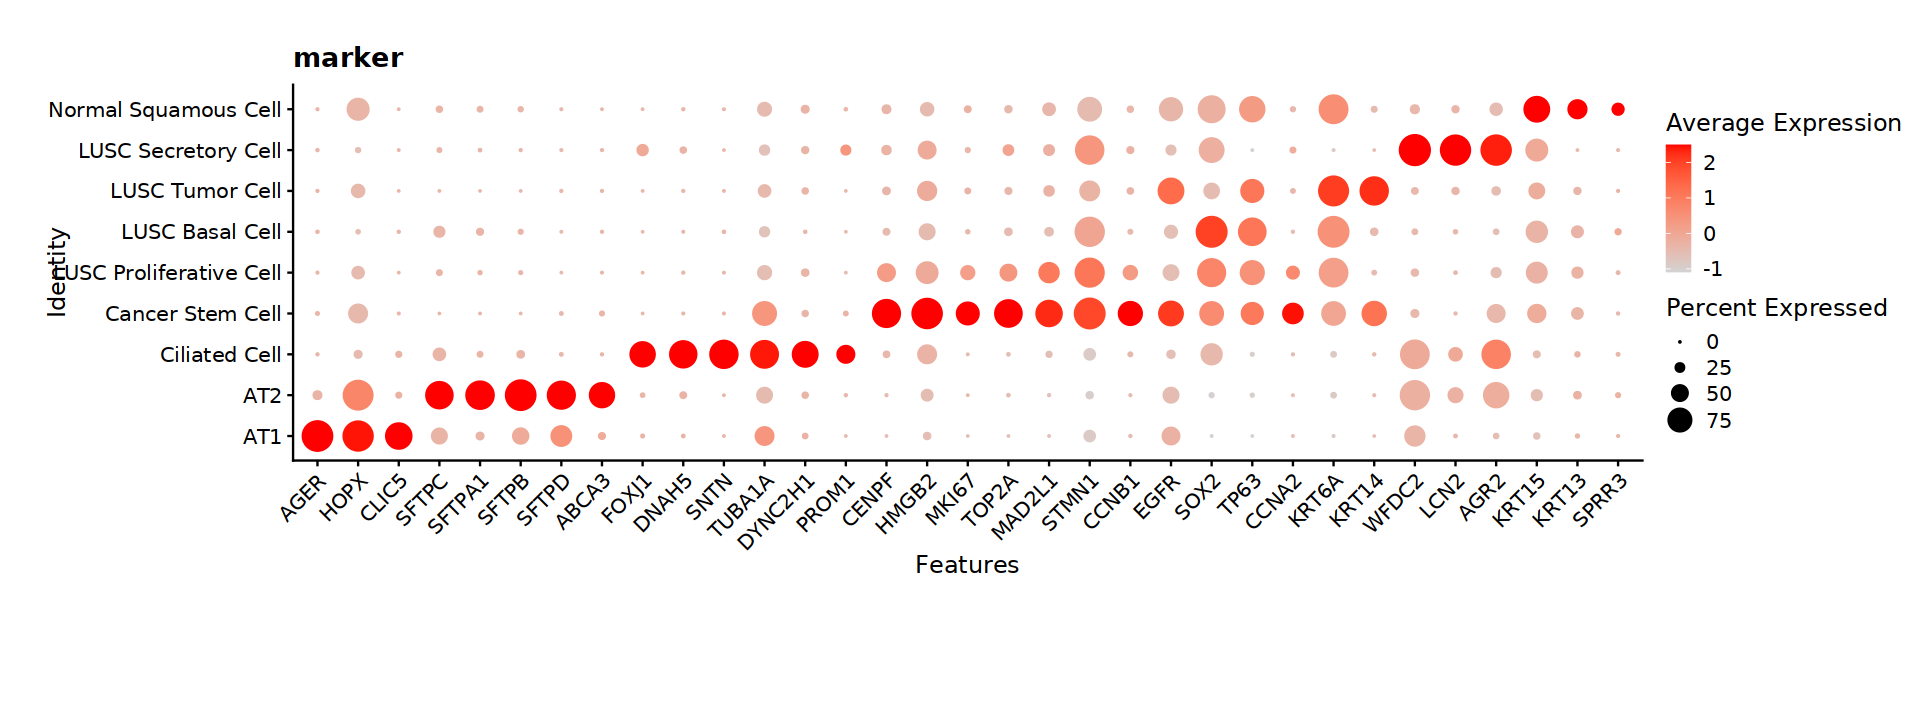

In [112]:
options(repr.plot.width=16, repr.plot.height=6)

marker_genes <- c(
  "AGER", "HOPX", "CLIC5",        # AT1
  "SFTPC", "SFTPA1", "SFTPB", "SFTPD", "ABCA3",   # AT2
  "FOXJ1", "DNAH5", "SNTN", "TUBA1A", "DYNC2H1",  # Ciliated  Cell
  "PROM1",'CENPF','HMGB2',    # Cancer Stem Cell
  "MKI67", "TOP2A",'MAD2L1','STMN1',"CCNB1",     # LUSC Proliferative Cell
  "EGFR", "SOX2",        # LUSC Basal Cell
  "TP63", 'CCNA2',"KRT6A", "KRT14",         # LUSC Tumor Cell
  "WFDC2", "LCN2", "AGR2",     # LUSC Secretory Cell
   'KRT15',"KRT13",'SPRR3'         # Normal Squamous Cell
)


p3 <- DotPlot(obj, cols = c("lightgrey", "red"),  features = marker_genes, group.by = 'Epi_celltype_plot', dot.scale = 8,cluster.idents = FALSE) + 
              theme(axis.text.x = element_text(angle = 45, vjust = 1, hjust = 1, size = 12),plot.margin = margin(1, 1, 3, 1, "cm")) +
              labs(title = "marker")
                   # x = "markers",
                   # y = "Seurat Clusters)

print(p3)
ggsave(paste0("../Dotplot_Epi_celltype.png"), bg='white', width=15,height=6, dpi = 300)
ggsave(paste0("../Dotplot_Epi_celltype.pdf"),width=15,height=6, dpi = 300)

### 2.3 featureplot

In [114]:
marker_genes <- c(
  "AGER", "HOPX", "CLIC5",        # AT1
  "SFTPC", "SFTPA1", "SFTPB", "SFTPD", "ABCA3",   # AT2
  "FOXJ1", "DNAH5", "SNTN", "TUBA1A", "DYNC2H1",  # Ciliated  Cell
  "PROM1",'CENPF','HMGB2',    # Cancer Stem Cell
  "MKI67", "TOP2A",'MAD2L1','STMN1',"CCNB1",     # LUSC Proliferative Cell
  "EGFR", "SOX2",        # LUSC Basal Cell
  "TP63", 'CCNA2',"KRT6A", "KRT14",         # LUSC Tumor Cell
  "WFDC2", "LCN2", "AGR2",     # LUSC Secretory Cell
   'KRT15',"KRT13",'SPRR3'         # Normal Squamous Cell
)

# 提取Seurat对象中实际存在的基因
existing_genes <- intersect(marker_genes, rownames(obj@assays$RNA@data))

# 生成缺失基因报告 ---------------------------------------------------------
missing_genes <- setdiff(marker_genes, existing_genes)
if (length(missing_genes) > 0) {
  message("\n以下基因在数据中缺失，将被跳过：\n", paste(missing_genes, collapse = ", "))
}

# 设置PDF设备参数
pdf("../featureplot/all_markers.pdf", width = 10, height = 10)
    
    for (gene in marker_genes) { # 循环绘制每个基因的FeaturePlot并写入PDF
      p <- FeaturePlot(obj, features = gene, cols = viridis(50, option = "D"), raster = FALSE) +  labs(title = gene)
      print(p)  # 关键：必须用print()输出到设备
    }
dev.off()  

# 单独保存每个基因的PNG
for (gene in marker_genes) {
  p <- FeaturePlot(obj, features = gene, cols = viridis(50, option = "D"), raster = FALSE) +  labs(title = gene)
  ggsave(paste0("../featureplot/", gene, ".png"), plot = p, width = 8, height = 8,  bg='white', dpi = 300)
}

pdf 
  2

### 2.4 celltype percent（Sankey_bar）

In [115]:
setwd('/data/work/02.result/others/Chen/proj_lusc/zbl/02.result/end_plot/epi_del/fig/')

In [117]:
obj$Epi_celltype <- factor(obj$Epi_celltype, levels = c('AT1','AT2','Ciliated Cell','Cancer Stem Cell','LUSC Proliferative Cell',
                                                                  'LUSC Basal Cell','LUSC Tumor Cell','LUSC Secretory Cell',
                                                                  'Normal Squamous Cell'))

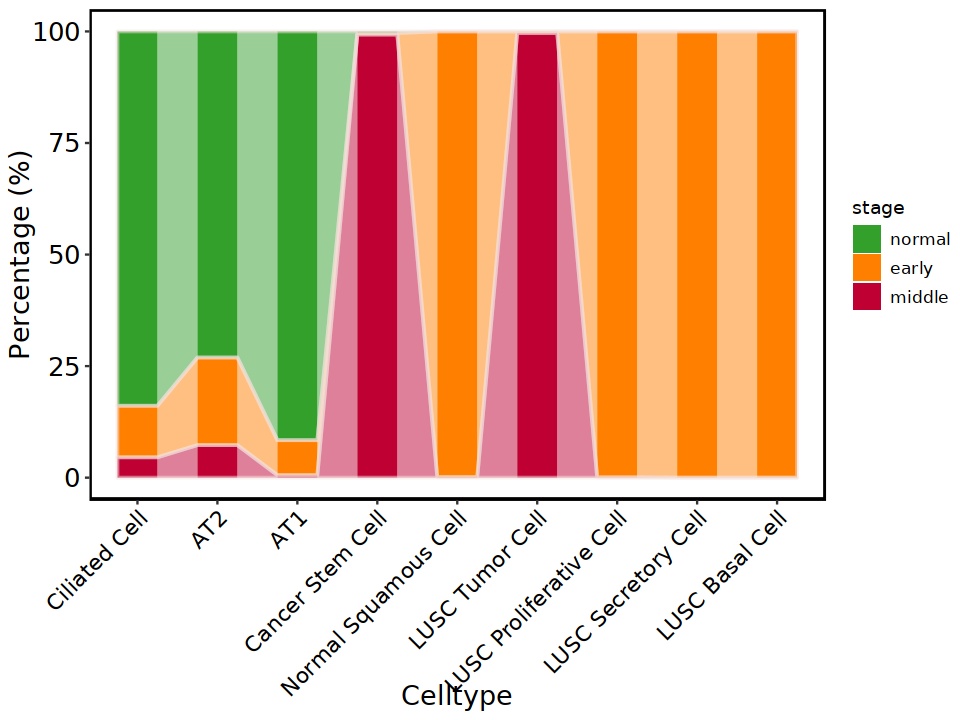

In [118]:
options(repr.plot.width=8, repr.plot.height=6)

# 绘制stage在细胞亚型中的流动分布
Sankey_bar(obj, 
             x_var = "Epi_celltype",
             y_var = "stage",
             color_palette = cor_stage,
             output_prefix = "percent_stage_Epi_celltype", width = 8, height = 6)

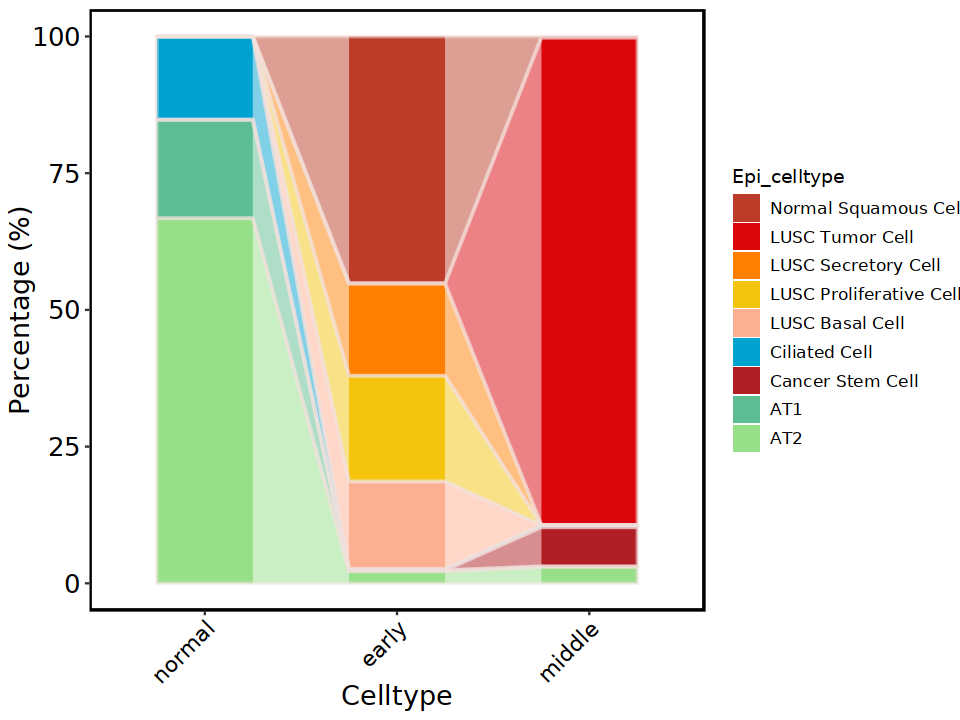

In [122]:
options(repr.plot.width=8, repr.plot.height=6)

# 绘制stage在细胞亚型中的流动分布
Sankey_bar(obj, 
             x_var = "stage",
             y_var = "Epi_celltype",
             color_palette = cor_epi,
             output_prefix = "percent_Epi_celltype_stage", width = 7, height = 8)

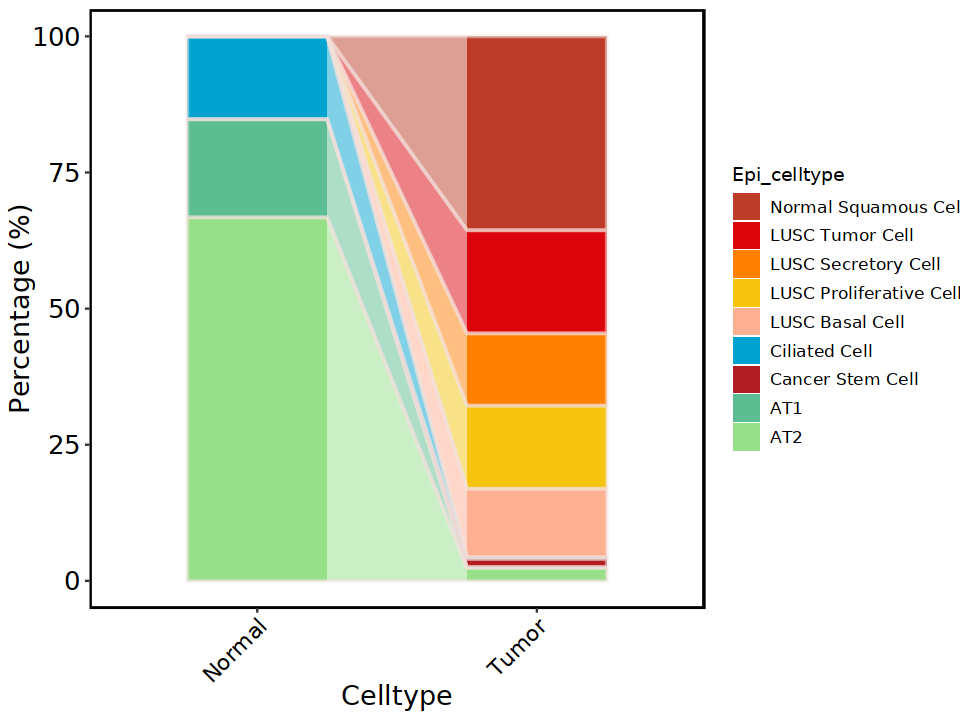

In [125]:
options(repr.plot.width=8, repr.plot.height=6)

# 绘制stage在细胞亚型中的流动分布
Sankey_bar(obj, 
             x_var = "type",
             y_var = "Epi_celltype",
             color_palette = cor_epi,
             output_prefix = "percent_Epi_celltype_type", width = 7, height = 8)

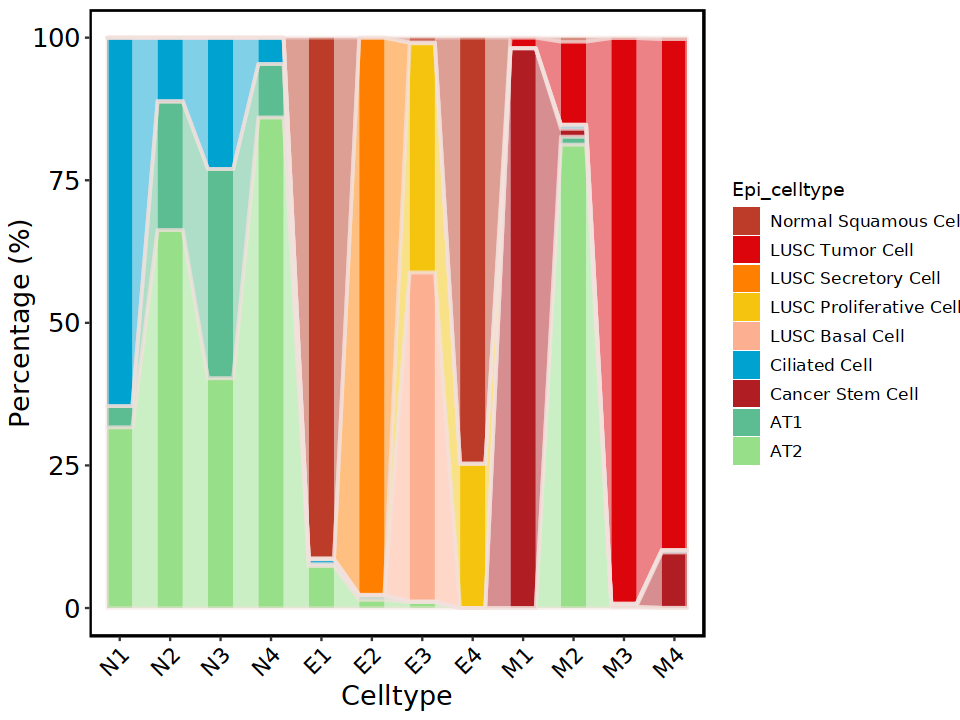

In [124]:
options(repr.plot.width=8, repr.plot.height=6)

# 绘制stage在细胞亚型中的流动分布
Sankey_bar(obj, 
             x_var = "sample",
             y_var = "Epi_celltype",
             color_palette = cor_epi,
             output_prefix = "percent_sample_celltype", width = 10, height = 6)

### 2.5 CLEC2B violin

In [127]:
library(Seurat)
library(ggplot2)
library(ggpubr)

# 假设obj_sub是您的Seurat对象
# 首先提取CLEC2B的表达数据
plot_data <- FetchData(obj, vars = c("CLEC2B", "stage"))
head(plot_data)

,CLEC2B,stage
,<dbl>,<fct>
p018_AAACGAACACTACAGT-1,0,normal
p018_AACAACCCACGCCAGT-1,0,normal
p018_AACCTTTTCTCTGGTC-1,0,normal
p018_AACGAAAAGGACCCAA-1,0,normal
p018_AACTTCTAGGCTGTAG-1,0,normal
p018_AAGCATCAGTAATCCC-1,0,normal


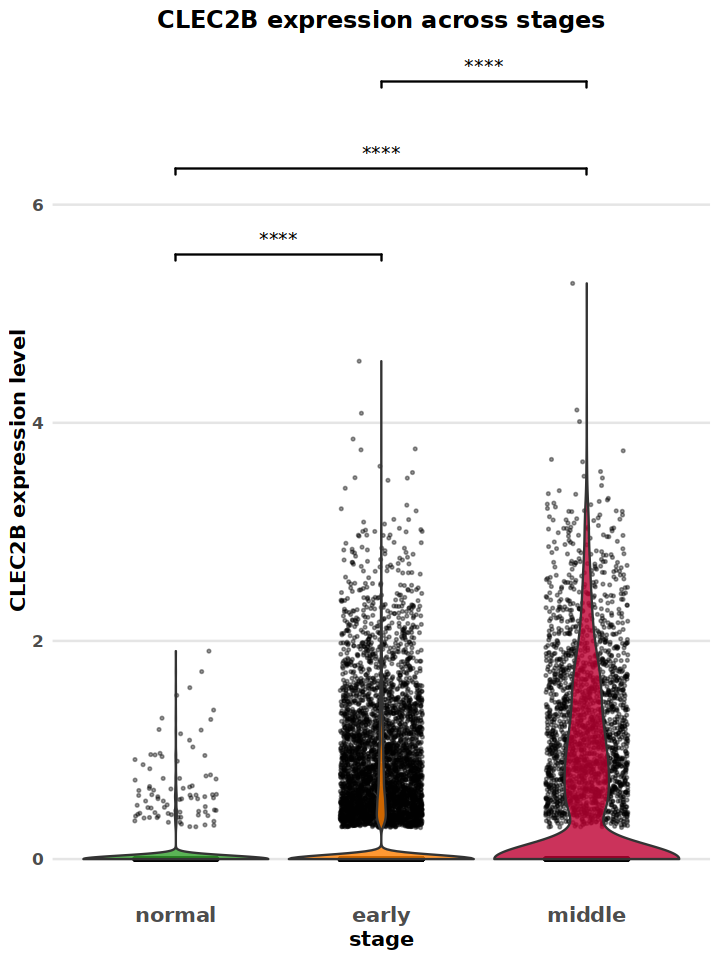

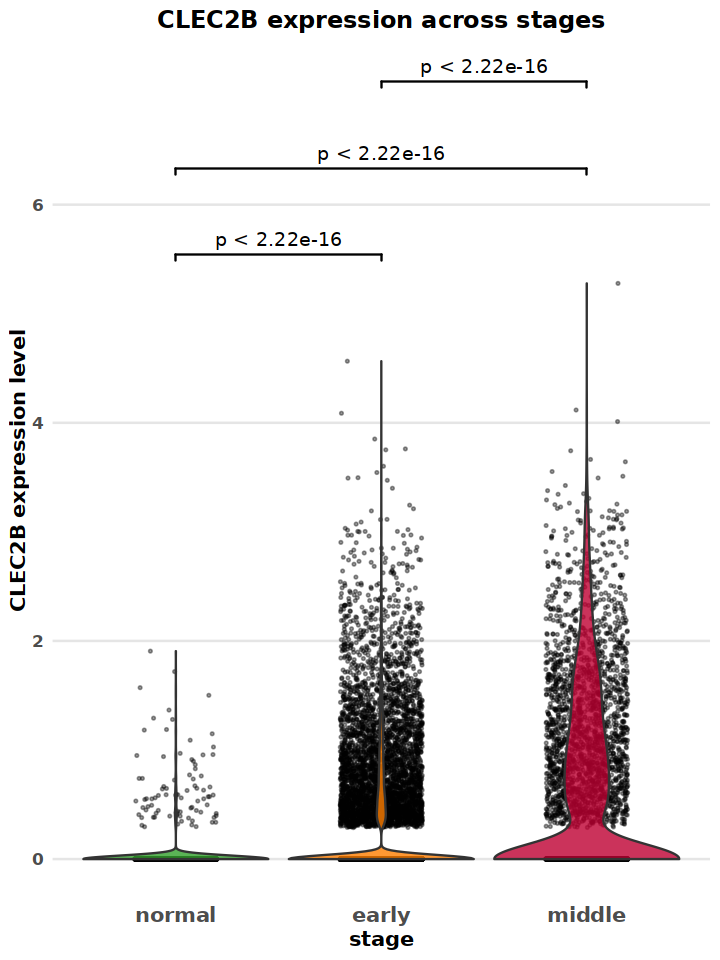

In [132]:
options(repr.plot.width=6,repr.plot.height=8)


# 定义美观的颜色方案
# stage_colors <- c("normal" = "#4DAF4A",  # 好看的绿色
#                  "early" = "#377EB8",   # 蓝色
#                  "middle" = "#E41A1C") # 红色

cor_stage <- c(
  "normal" = "#33A02C", # N系列 - 绿色系
  "early" = "#FF7F00", # E系列 - 黄色系
  "middle" = "#BE0032" # M系列 - 红色系
)

# 基础绘图
p <- ggplot(plot_data, aes(x = stage, y = CLEC2B, fill = stage)) +
        
        geom_jitter(width = 0.2, alpha = 0.4, size = 0.4, color = "black") +  # 散点(jitter避免重叠)
        geom_violin(scale = "width", trim = TRUE, alpha = 0.8) +  # 半透明小提琴图
        scale_fill_manual(values = cor_stage) +  # 应用自定义颜色
        scale_x_discrete(limits = c("normal", "early", "middle")) + # 确保顺序正确
              labs(
                y = "CLEC2B expression level",
                x = "stage",
                title = "CLEC2B expression across stages"
              ) +
                  theme_minimal(base_size = 12) +
                  theme(
                    legend.position = "none",
                    plot.title = element_text(hjust = 0.5, face = "bold", size = 14),
                    axis.title = element_text(face = "bold", size = 12),  # 坐标轴标题加粗
                    axis.text = element_text(face = "bold", size = 10),  # 坐标轴文本(包括分组标签)加粗
                    axis.text.x = element_text(face = "bold", size = 12), # 特别指定X轴文本加粗
                    panel.grid.major.y = element_line(color = "grey90"),
                    panel.grid.minor.y = element_blank(),
                    panel.grid.major.x = element_blank()
                  )

# 添加统计检验
p1 <- p + stat_compare_means(
  comparisons = list(
    c("normal", "early"),
    c("normal", "middle"),
    c("early", "middle")
  ),
  method = "wilcox.test", # 使用Wilcoxon秩和检验
  label = "p.signif", # 显示显著性标记
  tip.length = 0.01,
  size = 4,
  bracket.size = 0.5,
  step.increase = 0.15
)



p1
# 保存图片
ggsave("CLEC2B_expression_violin_signif.png", plot = p1, bg='white',width = 6, height = 8, dpi = 300)
ggsave("CLEC2B_expression_violin_signif.pdf", plot = p1, width = 6, height = 8, dpi = 300)

# 添加统计检验
p2 <- p + stat_compare_means(
  comparisons = list(
    c("normal", "early"),
    c("normal", "middle"),
    c("early", "middle")
  ),
  method = "wilcox.test", # 使用 Wilcoxon 秩和检验
  label = "p = {p.adj}", # 显示 p 值
  tip.length = 0.01,
  size = 4,
  bracket.size = 0.5,
  step.increase = 0.15
)


p2
# 保存图片
ggsave("CLEC2B_expression_violin_num.png", plot = p2, bg='white', width = 6, height = 8, dpi = 300)
ggsave("CLEC2B_expression_violin_num.pdf", plot = p2, width = 6, height = 8, dpi = 300)

### plot_volcano

In [136]:
data <- read.csv('../LUSC_tumor_markers.csv')
head(data,3)

,X,p_val,avg_log2FC,pct.1,pct.2,p_val_adj
,<chr>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>
1,GNB1,0,-0.6709705,0.586,0.818,0
2,CAMTA1,0,-0.6103554,0.569,0.814,0
3,CDA,0,0.3492732,0.199,0.024,0


In [146]:
plot_volcano (
  data, 
  output_file = "LUSC_tumor_volcano2.pdf",
  logFC_cutoff = 0.5, 
  pval_cutoff = 0.05,
  highlight_genes = 'CLEC2B',
  label_top = 5,
  xlim = NULL,
  ylim = c(0, 350),
  gene_col = "X", # 新增参数：指定基因列
  width = 6, height = 6
)

In [148]:
df <- read.csv('../Epi_celltype_markers_new.csv')
head(df,3)

,X,p_val,avg_log2FC,pct.1,pct.2,p_val_adj,cluster,gene
,<chr>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<chr>,<chr>
1,KRT13,0,3.745359,0.577,0.190,0,Normal Squamous Cell,KRT13
2,SPRR3,0,2.769783,0.335,0.050,0,Normal Squamous Cell,SPRR3
3,KRT15,0,2.481516,0.811,0.537,0,Normal Squamous Cell,KRT15


In [170]:
multi_cluster_volcano <- function(df,
                                  p_threshold = 0.05,
                                  fc_threshold = 1,
                                  sig_label = c("Up", "Down", "NS"),
                                  palette = c("#E64B35", "#3182BD", "grey80"),
                                  top_n = 5,
                                  label_genes = NULL,
                                  cluster_order = NULL,
                                  plot_style = "combined",
                                  font_size = 12) {
  
  suppressPackageStartupMessages({
    require(ggplot2); require(ggrepel); require(dplyr); require(tidyr)
  })
  
  # 关键修复：确保geneID为字符类型
  colnames(df)[1] <- "geneID"
  df$geneID <- as.character(df$geneID)  # 强制转换为字符
  
  stopifnot(all(c("geneID","p_val","avg_log2FC","cluster") %in% colnames(df)))
  
  df$cluster <- factor(df$cluster, levels = cluster_order %||% unique(df$cluster))
  
  df <- df %>% mutate(
    direction = case_when(
      avg_log2FC > fc_threshold & p_val < p_threshold ~ sig_label[1],
      avg_log2FC < -fc_threshold & p_val < p_threshold ~ sig_label[2],
      TRUE ~ sig_label[3]
    ) %>% factor(levels = sig_label)
  )
  
    
  #  标签数据处理 ----
  label_df <- if(is.null(label_genes)) {
  df %>% filter(direction != sig_label[3]) %>% 
    group_by(cluster, direction) %>% 
    slice_max(avg_log2FC, n = top_n) %>%  
    ungroup()
} else {
  df %>% filter(geneID %in% label_genes)
}

# 清理geneID，去除任何不必要的附加信息（如果有）：
    #label_df$geneID <- gsub("\\d+$", "", label_df$geneID)  # 去除基因名后的数字（如果有）
    label_df$geneID <- gsub("\\.[0-9]+$", "", label_df$geneID)  # 去除基因名中 . 后面的数字

# 绘图逻辑 ----
if(plot_style == "facet") {
  # 分面模式
  ggplot(df, aes(avg_log2FC, -log10(p_val))) +
    geom_point(aes(color = direction), alpha=0.7, size=1.5) +
    geom_text_repel(data = label_df, aes(label = geneID), size=font_size/3, max.overlaps=20) +
    facet_wrap(~cluster, scales = "free") +
    scale_color_manual(values = palette) +
    labs(x = "Log2(FoldChange)", y = "-Log10(p-value)") +
    theme_minimal(base_size = font_size)
  
} else {
  # 组合模式
  df_jitter <- df %>% 
    group_by(cluster) %>% 
    mutate(x_pos = as.numeric(cluster) + runif(n(), -0.2, 0.2)) %>%
    ungroup()
  
  label_jitter <- label_df %>% 
    group_by(cluster) %>% 
    mutate(x_pos = as.numeric(cluster) + runif(n(), -0.2, 0.2)) %>%
    ungroup()
  
  ggplot(df_jitter, aes(x_pos, avg_log2FC)) +
    geom_jitter(aes(color = direction), width=0.15, alpha=0.7, size=1.5) +
    #geom_boxplot(width=0.3, fill=NA, outlier.shape=NA) +
    geom_text_repel(data=label_jitter, aes(label=geneID), size=font_size/3, max.overlaps=20) +
    scale_x_continuous(breaks=seq_along(levels(df$cluster)), labels=levels(df$cluster)) +
    scale_color_manual(values = palette) +
    labs(x="Cluster", y="Log2(FoldChange)") +
    theme_minimal(base_size = font_size)+
    theme(
      axis.text.x = element_text(angle = 45, hjust = 1, vjust = 1,face = "bold", size = 12),         # 加粗并增大字号
      axis.title = element_text(face = "bold", size = 14),          # 坐标轴标题加粗增大
      legend.text = element_text(face = "bold", size = 11),         # 图例文字加粗
      legend.title = element_text(face = "bold", size = 12)         # 图例标题加粗
    )
    }
}

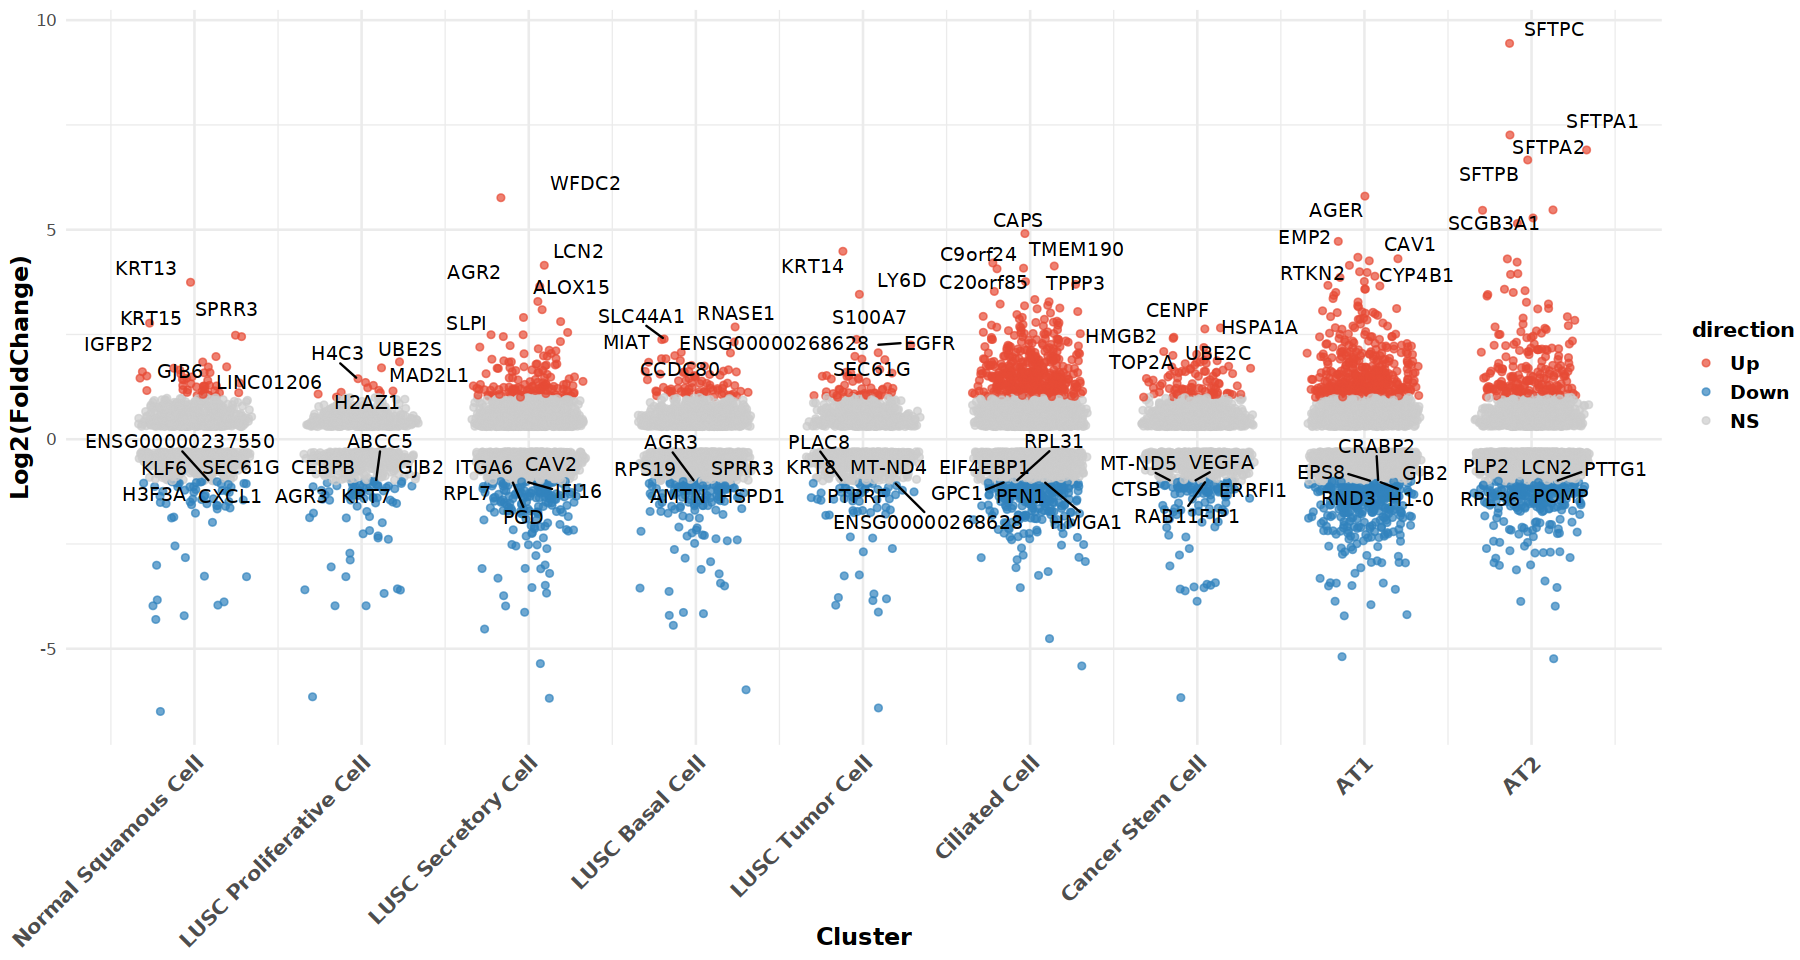

In [171]:
options(repr.plot.width=15,repr.plot.height=8)

p6 <- multi_cluster_volcano(df,
                              p_threshold = 0.05,
                              fc_threshold = 1,
                              sig_label = c("Up", "Down", "NS"),
                              palette = c("#E64B35", "#3182BD", "grey80"),
                              top_n = 5,
                              label_genes = NULL,
                              cluster_order = NULL,
                              plot_style = "combined", # 可选 "facet"分面或 "combined"合并
                              font_size = 12)
p6

#ggsave("Epi_celltype_multi_volcano.png", plot = p6, bg='white',width = 15, height = 7, dpi = 300)

## orthers